<img src="https://drive.google.com/uc?export=view&id=1wYSMgJtARFdvTt5g7E20mE4NmwUFUuog" width="200">

[![Build Fast with AI](https://img.shields.io/badge/BuildFastWithAI-GenAI%20Bootcamp-blue?style=for-the-badge&logo=artificial-intelligence)](https://www.buildfastwithai.com/genai-course)
[![EduChain GitHub](https://img.shields.io/github/stars/satvik314/educhain?style=for-the-badge&logo=github&color=gold)](https://github.com/satvik314/educhain)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1G3Jrl6IUlrZ6WDSqsF27PWnKX6Xl841Q#scrollTo=9Elqy-4zuoR-)
## Master Generative AI in 6 Weeks
**What You'll Learn:**
- Build with Latest LLMs
- Create Custom AI Apps
- Learn from Industry Experts
- Join Innovation Community
Transform your AI ideas into reality through hands-on projects and expert mentorship.
[Start Your Journey](https://www.buildfastwithai.com/genai-course)
*Empowering the Next Generation of AI Innovators

## 🛠️✨ **Haystack: Open Source NLP Framework by deepset**  
Haystack is an end-to-end framework that enables developers to build customizable, production-ready applications powered by Large Language Models (LLMs), Transformer models, and vector search. It supports tasks such as retrieval-augmented generation (RAG), question answering, semantic search, and conversational agents.


###**Setup and Installation**

**Install Required Libraries**


In [ ]:
!pip install git+https://github.com/deepset-ai/haystack.git@main#egg=haystack-ai haystack-ai datasets

###**Configure OpenAI API**

In [ ]:
import os
from getpass import getpass
from google.colab import userdata
userdata.get('OPENAI_API_KEY')


if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')


###**Conversational RAG using Memory**

In [ ]:
from haystack import Document
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.document_stores.in_memory import InMemoryDocumentStore
from datasets import load_dataset

dataset = load_dataset("bilgeyucel/seven-wonders", split="train")
docs = [Document(content=doc["content"], meta=doc["meta"]) for doc in dataset]

document_store = InMemoryDocumentStore()
document_store.write_documents(documents=docs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/46.0 [00:00<?, ?B/s]

(…)-00000-of-00001-4077bd623d55100a.parquet:   0%|          | 0.00/119k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/151 [00:00<?, ? examples/s]

151

###**Create DocumentStore and Index Documents**


In [ ]:
from haystack_experimental.chat_message_stores.in_memory import InMemoryChatMessageStore
from haystack_experimental.components.retrievers import ChatMessageRetriever
from haystack_experimental.components.writers import ChatMessageWriter

# Memory components
memory_store = InMemoryChatMessageStore()
memory_retriever = ChatMessageRetriever(memory_store)
memory_writer = ChatMessageWriter(memory_store)

###**Prompt Template for RAG with Memory**

In [ ]:
from haystack.dataclasses import ChatMessage

system_message = ChatMessage.from_system("You are a helpful AI assistant using provided supporting documents and conversation history to assist humans")

user_message_template ="""Given the conversation history and the provided supporting documents, give a brief answer to the question.
Note that supporting documents are not part of the conversation. If question can't be answered from supporting documents, say so.

    Conversation history:
    {% for memory in memories %}
        {{ memory.text }}
    {% endfor %}

    Supporting documents:
    {% for doc in documents %}
        {{ doc.content }}
    {% endfor %}

    \nQuestion: {{query}}
    \nAnswer:
"""
user_message = ChatMessage.from_user(user_message_template)

###**Build the Pipeline**

In [ ]:
from itertools import chain
from typing import Any

from haystack import component
from haystack.core.component.types import Variadic


@component
class ListJoiner:
    def __init__(self, _type: Any):
        component.set_output_types(self, values=_type)

    def run(self, values: Variadic[Any]):
        result = list(chain(*values))
        return {"values": result}


In [ ]:
from typing import List
from haystack import Pipeline
from haystack.components.builders import ChatPromptBuilder, PromptBuilder
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.generators import OpenAIGenerator
from haystack.components.converters import OutputAdapter

pipeline = Pipeline()

# components for RAG
pipeline.add_component("retriever", InMemoryBM25Retriever(document_store=document_store, top_k=3))
pipeline.add_component("prompt_builder", ChatPromptBuilder(variables=["query", "documents", "memories"], required_variables=["query", "documents", "memories"]))
pipeline.add_component("llm", OpenAIChatGenerator())

# components for memory
pipeline.add_component("memory_retriever", memory_retriever)
pipeline.add_component("memory_writer", memory_writer)
pipeline.add_component("memory_joiner", ListJoiner(List[ChatMessage]))

# connections for RAG
pipeline.connect("retriever.documents", "prompt_builder.documents")
pipeline.connect("prompt_builder.prompt", "llm.messages")
pipeline.connect("llm.replies", "memory_joiner")

# connections for memory
pipeline.connect("memory_joiner", "memory_writer")
pipeline.connect("memory_retriever", "prompt_builder.memories")

🚅 Components
  - retriever: InMemoryBM25Retriever
  - prompt_builder: ChatPromptBuilder
  - llm: OpenAIChatGenerator
  - memory_retriever: ChatMessageRetriever
  - memory_writer: ChatMessageWriter
  - memory_joiner: ListJoiner
🛤️ Connections
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.messages (List[ChatMessage])
  - llm.replies -> memory_joiner.values (List[ChatMessage])
  - memory_retriever.messages -> prompt_builder.memories (List[ChatMessage])
  - memory_joiner.values -> memory_writer.messages (List[ChatMessage])

###**Visualize the pipeline**

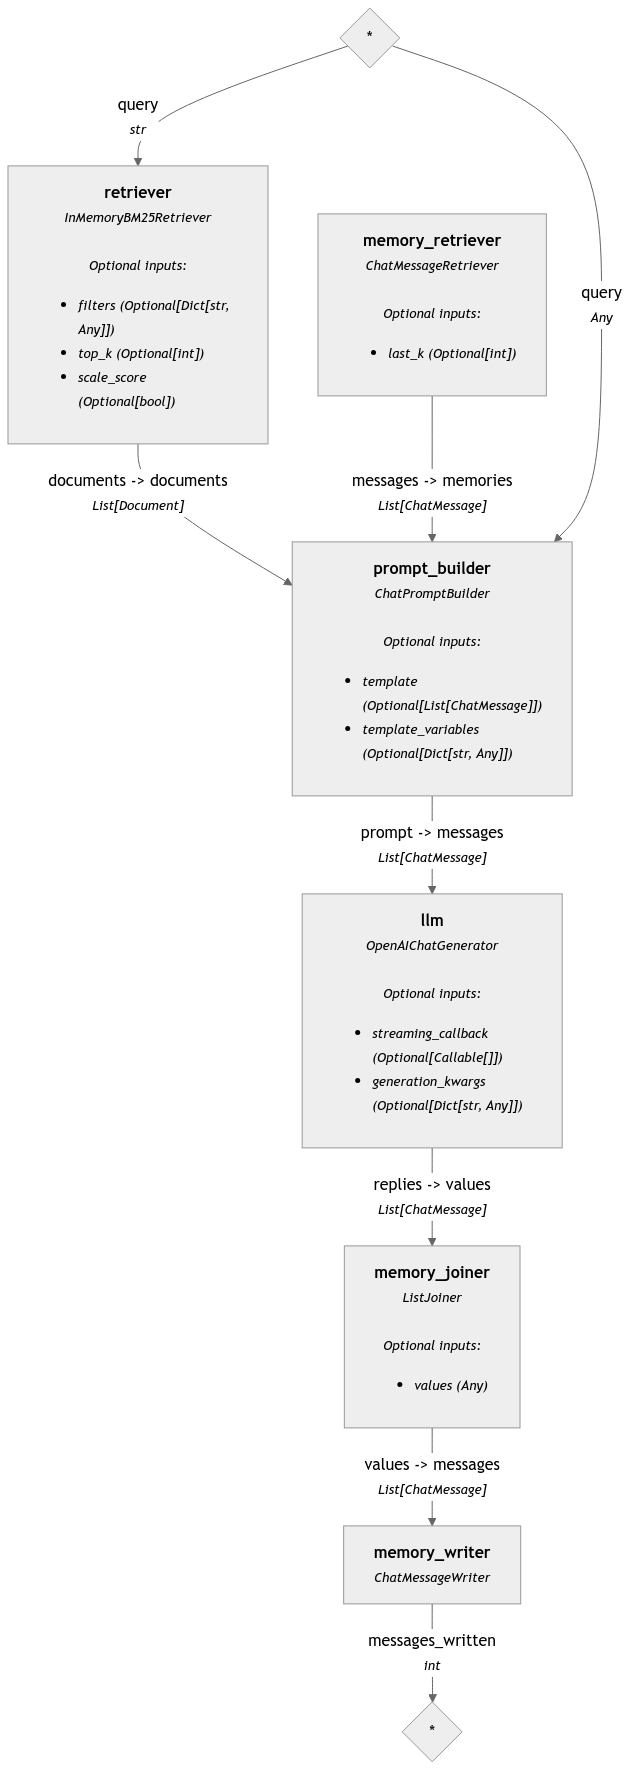

In [ ]:
pipeline.show()

###**Run the Pipeline**

In [ ]:
while True:
  messages = [system_message, user_message]
  question = input("Enter your question or Q to exit.\n ")
  if question == "Q":
    break

  res = pipeline.run(data={"retriever": {"query": question},
                             "prompt_builder": {"template": messages, "query": question},
                             "memory_joiner": {"values": [ChatMessage.from_user(question)]}},
                             include_outputs_from=["llm"])
  assistant_resp = res['llm']['replies'][0]
  print(f" {assistant_resp.text}")  # Use text property instead of content

Enter your question or Q to exit.
 q
 I'm sorry, but I cannot provide an answer as there is no relevant supporting document or conversation history provided.
Enter your question or Q to exit.
 Q


###**Chat With Your SQL Database**

In [ ]:
from urllib.request import urlretrieve
from zipfile import ZipFile
import pandas as pd

url = "https://archive.ics.uci.edu/static/public/445/absenteeism+at+work.zip"

# download the file
urlretrieve(url, "Absenteeism_at_work_AAA.zip")

print("Extracting the Absenteeism at work dataset...")
# Extract the CSV file
with ZipFile("Absenteeism_at_work_AAA.zip", 'r') as zf:
    zf.extractall()

# Check the extracted CSV file name (in this case, it's "Absenteeism_at_work.csv")
csv_file_name = "Absenteeism_at_work.csv"

print("Cleaning up the Absenteeism at work dataset...")
# Data clean up
df = pd.read_csv(csv_file_name, sep=";")
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('/', '_')

Extracting the Absenteeism at work dataset...
Cleaning up the Absenteeism at work dataset...


In [ ]:
columns = df.columns.to_list()
columns = ', '.join(columns)
columns

'ID, Reason_for_absence, Month_of_absence, Day_of_the_week, Seasons, Transportation_expense, Distance_from_Residence_to_Work, Service_time, Age, Work_load_Average_day_, Hit_target, Disciplinary_failure, Education, Son, Social_drinker, Social_smoker, Pet, Weight, Height, Body_mass_index, Absenteeism_time_in_hours'

###**Create a SQL Query Component**


In [ ]:
import sqlite3

connection = sqlite3.connect('absenteeism.db')
print("Opened database successfully");

connection.execute('''CREATE TABLE IF NOT EXISTS absenteeism (ID integer,
                        Reason_for_absence integer,
                        Month_of_absence integer,
                        Day_of_the_week integer,
                        Seasons integer,
                        Transportation_expense integer,
                        Distance_from_Residence_to_Work integer,
                        Service_time integer,
                        Age integer,
                        Work_load_Average_day_ integer,
                        Hit_target integer,
                        Disciplinary_failure integer,
                        Education integer,
                        Son integer,
                        Social_drinker integer,
                        Social_smoker integer,
                        Pet integer,
                        Weight integer,
                        Height integer,
                        Body_mass_index integer,
                        Absenteeism_time_in_hours integer);''')
connection.commit()

Opened database successfully


In [ ]:
df.to_sql('absenteeism', connection, if_exists='replace', index = False)

740

In [ ]:
connection.close()


In [ ]:
@component
class SQLQuery:

    def __init__(self, sql_database: str):
      self.connection = sqlite3.connect(sql_database, check_same_thread=False)

    @component.output_types(results=List[str], queries=List[str])
    def run(self, queries: List[str]):
        results = []
        for query in queries:
          result = pd.read_sql(query, self.connection)
          results.append(f"{result}")
        return {"results": results, "queries": queries}

###**Try the SQLQuery Component**

In [ ]:
sql_query = SQLQuery('absenteeism.db')


In [ ]:

result = sql_query.run(queries=['SELECT Age, SUM(Absenteeism_time_in_hours) as Total_Absenteeism_Hours FROM absenteeism WHERE Disciplinary_failure = 0 GROUP BY Age ORDER BY Total_Absenteeism_Hours DESC LIMIT 3;'])
print(result["results"][0])


   Age  Total_Absenteeism_Hours
0   28                      651
1   33                      538
2   38                      482


###**Query A SQL Database with Natural Language**


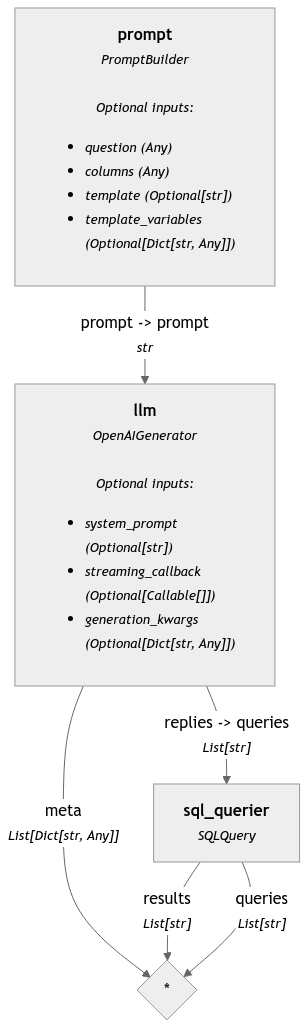

In [ ]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.generators.openai import OpenAIGenerator

prompt = PromptBuilder(template="""Please generate an SQL query. The query should answer the following Question: {{question}};
            The query is to be answered for the table is called 'absenteeism' with the following
            Columns: {{columns}};
            Answer:""")
sql_query = SQLQuery('absenteeism.db')
llm = OpenAIGenerator(model="gpt-4")

sql_pipeline = Pipeline()
sql_pipeline.add_component("prompt", prompt)
sql_pipeline.add_component("llm", llm)
sql_pipeline.add_component("sql_querier", sql_query)

sql_pipeline.connect("prompt", "llm")
sql_pipeline.connect("llm.replies", "sql_querier.queries")

# If you want to draw the pipeline, uncomment below 👇
sql_pipeline.show()


In [ ]:
result = sql_pipeline.run({"prompt": {"question": "On which days of the week does the average absenteeism time exceed 4 hours?",
                            "columns": columns}})

print(result["sql_querier"]["results"][0])

   Day_of_the_week  Average_Absenteeism
0                2             9.248447
1                3             7.980519
2                4             7.147436
3                5             4.424000
4                6             5.125000


In [ ]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.generators.openai import OpenAIGenerator
from haystack.components.routers import ConditionalRouter

prompt = PromptBuilder(template="""Please generate an SQL query. The query should answer the following Question: {{question}};
            If the question cannot be answered given the provided table and columns, return 'no_answer'
            The query is to be answered for the table is called 'absenteeism' with the following
            Columns: {{columns}};
            Answer:""")

llm = OpenAIGenerator(model="gpt-4")
sql_query = SQLQuery('absenteeism.db')

routes = [
     {
        "condition": "{{'no_answer' not in replies[0]}}",
        "output": "{{replies}}",
        "output_name": "sql",
        "output_type": List[str],
    },
    {
        "condition": "{{'no_answer' in replies[0]}}",
        "output": "{{question}}",
        "output_name": "go_to_fallback",
        "output_type": str,
    },
]

router = ConditionalRouter(routes)

fallback_prompt = PromptBuilder(template="""User entered a query that cannot be answerwed with the given table.
                                            The query was: {{question}} and the table had columns: {{columns}}.
                                            Let the user know why the question cannot be answered""")
fallback_llm = OpenAIGenerator(model="gpt-4")

conditional_sql_pipeline = Pipeline()
conditional_sql_pipeline.add_component("prompt", prompt)
conditional_sql_pipeline.add_component("llm", llm)
conditional_sql_pipeline.add_component("router", router)
conditional_sql_pipeline.add_component("fallback_prompt", fallback_prompt)
conditional_sql_pipeline.add_component("fallback_llm", fallback_llm)
conditional_sql_pipeline.add_component("sql_querier", sql_query)

conditional_sql_pipeline.connect("prompt", "llm")
conditional_sql_pipeline.connect("llm.replies", "router.replies")
conditional_sql_pipeline.connect("router.sql", "sql_querier.queries")
conditional_sql_pipeline.connect("router.go_to_fallback", "fallback_prompt.question")
conditional_sql_pipeline.connect("fallback_prompt", "fallback_llm")

#if you want to draw the pipeline, uncomment below 👇

#conditional_sql_pipeline.show()

🚅 Components
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
  - router: ConditionalRouter
  - fallback_prompt: PromptBuilder
  - fallback_llm: OpenAIGenerator
  - sql_querier: SQLQuery
🛤️ Connections
  - prompt.prompt -> llm.prompt (str)
  - llm.replies -> router.replies (List[str])
  - router.sql -> sql_querier.queries (List[str])
  - router.go_to_fallback -> fallback_prompt.question (str)
  - fallback_prompt.prompt -> fallback_llm.prompt (str)

In [ ]:

question = "When is my birthday?"
result = conditional_sql_pipeline.run({"prompt": {"question": question,
                                                  "columns": columns},
                                       "router": {"question": question},
                                       "fallback_prompt": {"columns": columns}})
if 'sql_querier' in result:
  print(result['sql_querier']['results'][0])
elif 'fallback_llm' in result:
  print(result['fallback_llm']['replies'][0])


The question cannot be answered as your personal data, such as your birthday, is not contained or relevant in the given table. The table is only about absence from work data, and it does not include individual-specific personal data. Please provide a relevant query to get an appropriate output from this data.


###**Function Calling to Query a SQL Database**


In [ ]:

sql_query = SQLQuery('absenteeism.db')

def sql_query_func(queries: List[str]):
    try:
      result = sql_query.run(queries)
      return {"reply": result["results"][0]}

    except Exception as e:
      reply = f"""There was an error running the SQL Query = {queries}
              The error is {e},
              You should probably try again.
              """
      return {"reply": reply}


###**Define Tools**

In [ ]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "sql_query_func",
            "description": f"This a tool useful to query a SQL table called 'absenteeism' with the following Columns: {columns}",
            "parameters": {
                "type": "object",
                "properties": {
                    "queries": {
                        "type": "array",
                        "description": "The query to use in the search. Infer this from the user's message. It should be a question or a statement",
                        "items": {
                            "type": "string",
                        }
                    }
                },
                "required": ["question"],
            },
        },
    }
]

###**Try The Tool**

In [ ]:
from haystack.dataclasses import ChatMessage
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.generators.utils import print_streaming_chunk

messages = [
    ChatMessage.from_system(
        "You are a helpful and knowledgeable agent who has access to an SQL database which has a table called 'absenteeism'"
    ),
    ChatMessage.from_user("On which days of the week does the average absenteeism time exceed 4 hours??"),
]

chat_generator = OpenAIChatGenerator(model="gpt-4", streaming_callback=print_streaming_chunk)
response = chat_generator.run(messages=messages, generation_kwargs={"tools": tools})
print(response)


{'replies': [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='[{"index": 0, "id": "call_esv4XqKQf8p5XZMfs07F64LE", "function": {"arguments": "{\\n  \\"queries\\": [\\"SELECT Day_of_the_week, AVG(Absenteeism_time_in_hours) as Average_Absenteeism FROM absenteeism GROUP BY Day_of_the_week HAVING Average_Absenteeism > 4\\"]\\n}", "name": "sql_query_func"}, "type": "function"}]')], _name=None, _meta={'model': 'gpt-4-0613', 'index': 0, 'finish_reason': 'tool_calls', 'usage': {}})]}


In [ ]:
from haystack.dataclasses import ChatMessage
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.generators.utils import print_streaming_chunk

messages = [
    ChatMessage.from_system(
        "You are a helpful and knowledgeable agent who has access to an SQL database which has a table called 'absenteeism'"
    ),
    ChatMessage.from_user("On which days of the week does the average absenteeism time exceed 4 hours??"),
]

chat_generator = OpenAIChatGenerator(model="gpt-4", streaming_callback=print_streaming_chunk)
response = chat_generator.run(messages=messages, generation_kwargs={"tools": tools})
print(response)


{'replies': [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='[{"index": 0, "id": "call_0mHJF8cXRVBq6lVAQpJNUZeR", "function": {"arguments": "{\\n  \\"queries\\": [\\"SELECT Day_of_the_week, AVG(Absenteeism_time_in_hours) as Average_absenteeism FROM absenteeism GROUP BY Day_of_the_week HAVING AVG(Absenteeism_time_in_hours) > 4\\"]\\n}", "name": "sql_query_func"}, "type": "function"}]')], _name=None, _meta={'model': 'gpt-4-0613', 'index': 0, 'finish_reason': 'tool_calls', 'usage': {}})]}
